## Dự đoán giá lúa

### Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px

from scipy import stats
%matplotlib inline


import xgboost as xgb

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

### Dữ liệu

In [2]:
df = pd.read_csv('./data.csv',  parse_dates=['date'], index_col='date')

In [3]:
df.head()

,price
date,
2008-01-15,5331.605
2008-02-15,5787.000
2008-03-15,6549.875
2008-04-15,7222.500
2008-05-15,8588.890


### EDA

In [4]:
print('Total num of missing values:') 
print(df.price.isna().sum())
df.price.isna()

Total num of missing values:
0


date
2008-01-15    False
2008-02-15    False
2008-03-15    False
2008-04-15    False
2008-05-15    False
              ...  
2023-05-15    False
2023-06-15    False
2023-07-15    False
2023-08-15    False
2023-09-15    False
Name: price, Length: 189, dtype: bool

In [5]:
dataset = df.copy()
dataset = dataset.resample('W').ffill()
# Split train data and test data
train_size = int(len(dataset)*0.8)

# train_data = df.WC.loc[:train_size] -----> it gives a series
# Do not forget use iloc to select a number of rows
train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

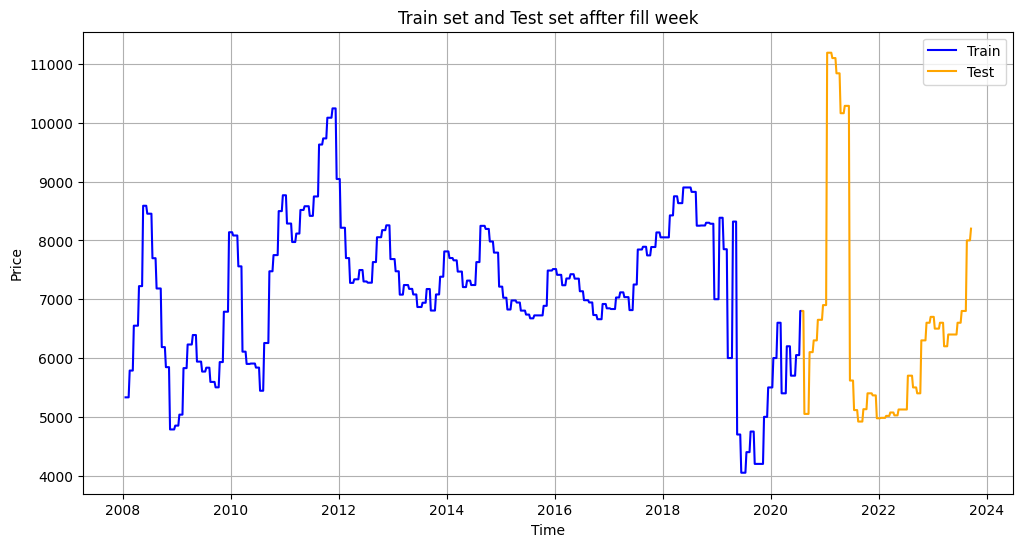

In [6]:
import matplotlib.pyplot as plt

# Vẽ đường RMSE cho tập train và test
plt.figure(figsize=(12, 6))

# Vẽ đường ground truth cho tập train
plt.plot(train_data['price'], label='Train', color='blue')

# Vẽ đường ground truth cho tập test
plt.plot(test_data['price'], label='Test', color='orange')

# Đặt tiêu đề và chú thích
plt.title('Train set and Test set affter fill week')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [7]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [8]:
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (654, 1)
Test data shape:  (164, 1)


In [9]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset(X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.squeeze(np.array(Xs), axis=-1), np.array(ys),
# Gia 12 thang
look_back = 48
X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (606, 48)
y_train.shape:  (606, 1)
X_test.shape:  (116, 48)
y_test.shape:  (116, 1)


In [10]:
from sklearn.metrics import r2_score

def evaluate_predict(model, x, y, name_model):

    y_pred = model.predict(x)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_label = scaler.inverse_transform(y)

    # Evaluate the model
    mse = mean_squared_error(y_label, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_label, y_pred)
   
    print("Đánh giá mô hình " + name_model)
    df_eval = pd.DataFrame(data= {'MSE': [mse], 'RMSE': [rmse], "R2": [r2]})
    return df_eval

In [11]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 12):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])

    return np.array(Xs), np.array(ys)
# Gia 12 thang
look_back = 48
X_rnn_train, y_rnn_train = create_dataset(train_scaled, look_back)
X_rnn_test, y_rnn_test = create_dataset(test_scaled, look_back)

In [12]:
def predict_model(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predict_model_oil(model, x):
    prediction = model.predict(x)
    prediction = scaler.inverse_transform(prediction.reshape(-1, 1))
    return prediction

In [13]:
def plot_future(prediction, model_name, y_plot_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    y_plot_test =  scaler.inverse_transform(y_plot_test)
    plt.plot(np.arange(range_future), np.array(y_plot_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
       

### LSTM

In [14]:
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM(units = units, return_sequences=True, 
                            input_shape=(X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(LSTM(units = units, return_sequences=True))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
   
model_lstm = create_lstm(64)

### GRU

In [15]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = (X_rnn_train.shape[1], X_rnn_train.shape[2])))
    model.add(Dropout(0.2)) 
      # Hidden layer
    model.add(GRU (units = units,  return_sequences=True))                
    model.add(Dropout(0.2))
    # Hidden layer
    model.add(GRU(units = units))                        
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
   
    return model
model_gru = create_gru(64)

In [16]:
def fit_model(model):
    history = model.fit(X_rnn_train, y_rnn_train, epochs = 100, batch_size = 32, shuffle = False)
    return history

In [17]:
history_gru = fit_model(model_gru)

Epoch 1/100
19/19 [==============================] - 10s 136ms/step - loss: 0.0510
Epoch 2/100
19/19 [==============================] - 1s 79ms/step - loss: 0.0189
Epoch 3/100
19/19 [==============================] - 3s 149ms/step - loss: 0.0146
Epoch 4/100
19/19 [==============================] - 2s 87ms/step - loss: 0.0107
Epoch 5/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0101
Epoch 6/100
19/19 [==============================] - 1s 48ms/step - loss: 0.0084
Epoch 7/100
19/19 [==============================] - 1s 40ms/step - loss: 0.0081
Epoch 8/100
19/19 [==============================] - 1s 40ms/step - loss: 0.0078
Epoch 9/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0076
Epoch 10/100
19/19 [==============================] - 1s 51ms/step - loss: 0.0070
Epoch 11/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0073
Epoch 12/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0075
Epoch 13/100
19/19 [==

In [18]:
history_lstm = fit_model(model_lstm)

Epoch 1/100
19/19 [==============================] - 6s 43ms/step - loss: 0.0513
Epoch 2/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0192
Epoch 3/100
19/19 [==============================] - 1s 36ms/step - loss: 0.0194
Epoch 4/100
19/19 [==============================] - 1s 38ms/step - loss: 0.0184
Epoch 5/100
19/19 [==============================] - 1s 40ms/step - loss: 0.0178
Epoch 6/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0153
Epoch 7/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0137
Epoch 8/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0124
Epoch 9/100
19/19 [==============================] - 1s 49ms/step - loss: 0.0118
Epoch 10/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0114
Epoch 11/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0104
Epoch 12/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0097
Epoch 13/100
19/19 [=====

In [ ]:
evaluate_predict(model_gru, X_rnn_train, y_rnn_train, 'GRU trên tập train').head()

19/19 [==============================] - 2s 22ms/step
Đánh giá mô hình GRU trên tập train


,MSE,RMSE,R2
0,129414.780658,359.742659,0.905663


In [ ]:
y_pred = model_gru.predict(X_rnn_train)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_label = scaler.inverse_transform(y_rnn_train)

19/19 [==============================] - 1s 27ms/step


In [ ]:
y_pred.shape

(606, 1)

In [ ]:
y_label.shape

(606, 1)

In [ ]:
evaluate_predict(model_gru, X_rnn_test, y_rnn_test, 'GRU trên tập test').head()

3/4 [=====================>........] - ETA: 0s

4/4 [==============================] - 0s 31ms/step
Đánh giá mô hình GRU trên tập test


,MSE,RMSE,R2
0,73162.33314,270.485366,0.88819


In [ ]:
evaluate_predict(model_lstm, X_rnn_train, y_rnn_train, 'LSMT trên tập train').head()

19/19 [==============================] - 3s 20ms/step
Đánh giá mô hình LSMT trên tập train


,MSE,RMSE,R2
0,88876.517798,298.121649,0.935213


In [ ]:
evaluate_predict(model_lstm, X_rnn_test, y_rnn_test, 'LSTM trên tập test').head()

3/4 [=====================>........] - ETA: 0s

4/4 [==============================] - 0s 22ms/step
Đánh giá mô hình LSTM trên tập test


,MSE,RMSE,R2
0,57617.166142,240.03576,0.911947


1/4 [======>.......................] - ETA: 0s

19/19 [==============================] - 0s 17ms/step


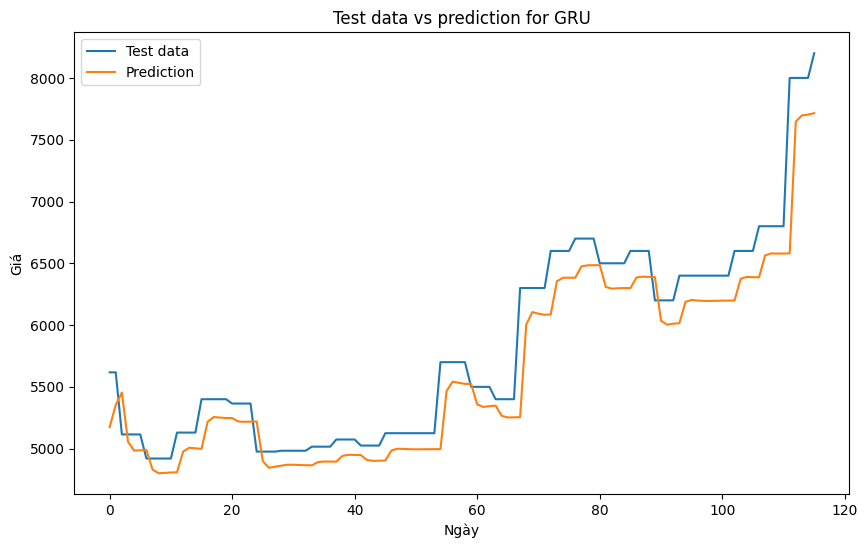

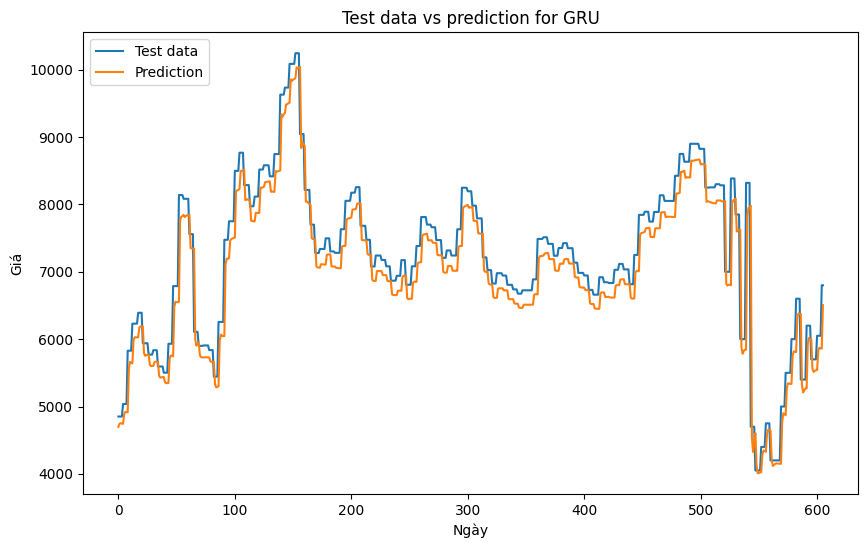

In [ ]:
plot_future(predict_model(model_gru, X_rnn_test), 'GRU', y_rnn_test)
plot_future(predict_model(model_gru, X_rnn_train), 'GRU', y_rnn_train)

1/4 [======>.......................] - ETA: 0s

19/19 [==============================] - 0s 20ms/step


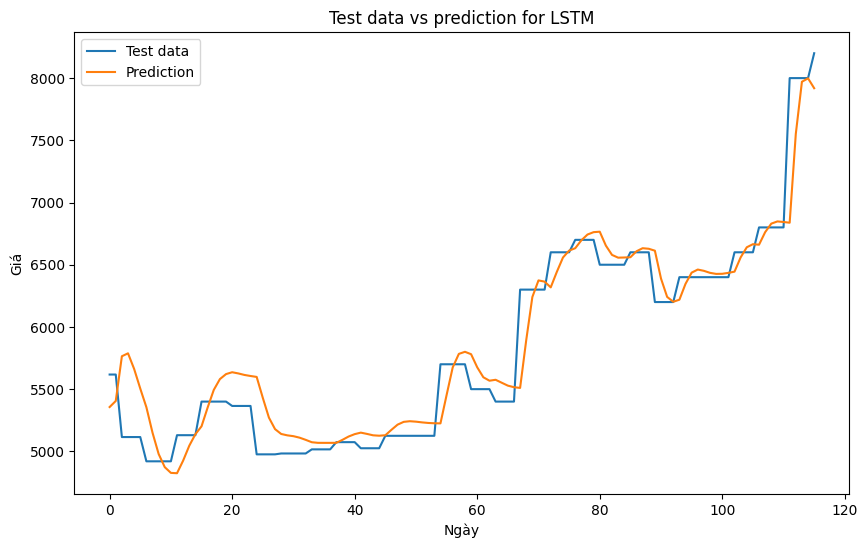

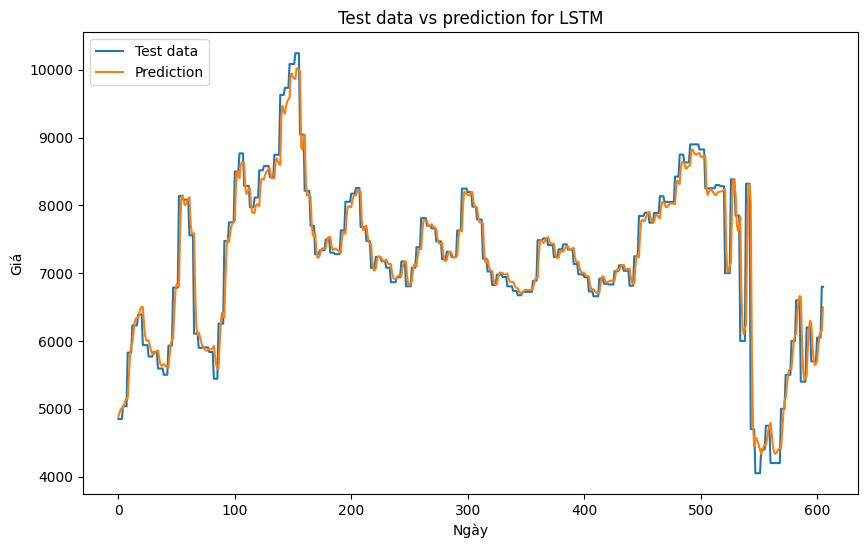

In [ ]:
plot_future(predict_model(model_lstm, X_rnn_test), 'LSTM', y_rnn_test)
plot_future(predict_model(model_lstm, X_rnn_train), 'LSTM', y_rnn_train)

### Dự đoán 

In [ ]:
def predict(forecast_num, model,data,look_back):
  prediction_list = data[-look_back:]

  for _ in range(forecast_num):
      x = prediction_list[-look_back:]
      x = x.reshape((1, look_back, 1))
      out = model.predict(x)[0][0]
      prediction_list = np.append(prediction_list, out)
  prediction_list = prediction_list[look_back-1:]

  return prediction_list

def predict_dates(forecast_num, data):
    last_date = data.index[-1]
    prediction_dates = pd.date_range(last_date, periods=forecast_num+1).tolist()
    return prediction_dates

def predict_new_date(model, days, timestep):
  forecast_num = 12 #number of day to predict after the last date in data
  forecast=predict(days, model=model,data=X_test[-1:],look_back=timestep)
  forecast_date=predict_dates(forecast_num, df)
  return scaler.inverse_transform(forecast.reshape(-1, 1))

1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 28ms/step


Text(0, 0.5, 'Giá')

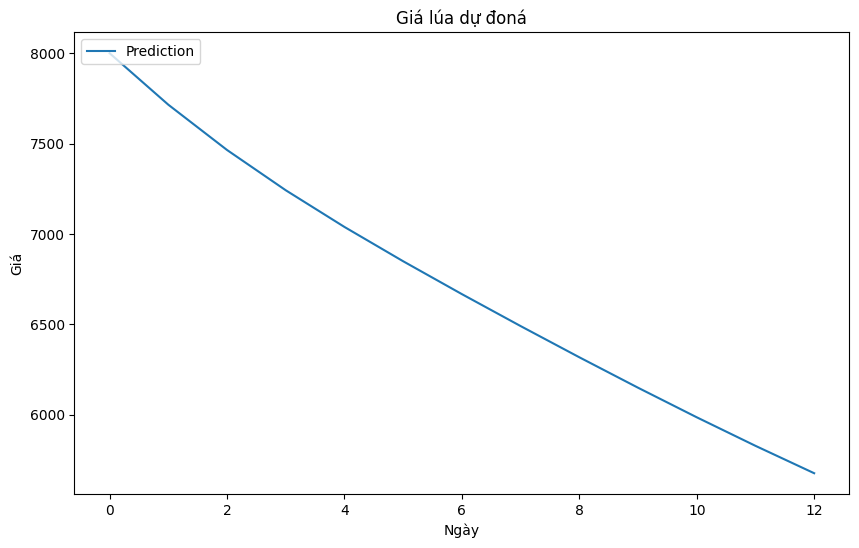

In [ ]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_gru, 12, 48)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá lúa dự đoná')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

1/1 [==============================] - 0s 49ms/step


Text(0, 0.5, 'Giá')

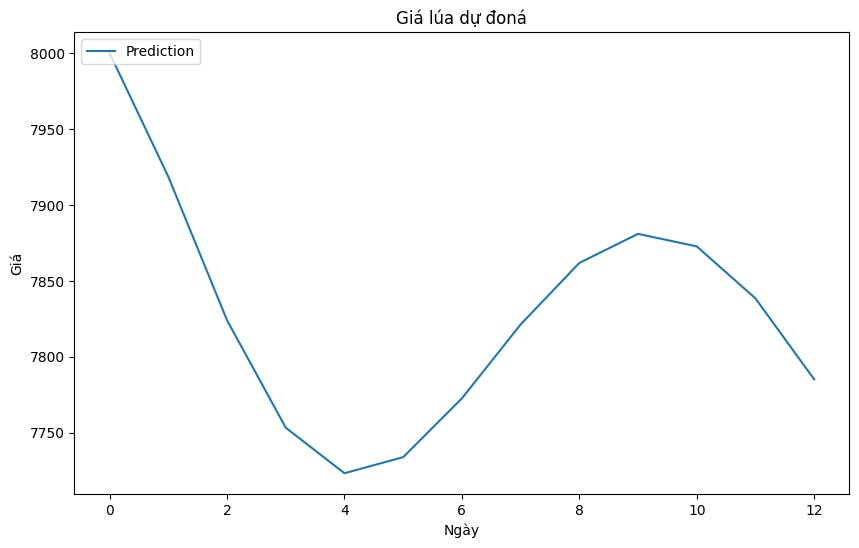

In [ ]:
plt.figure(figsize=(10, 6))

data_pred = predict_new_date(model_lstm, 12, 48)    
plt.plot(np.array(data_pred),label='Prediction')

plt.title('Giá lúa dự đoná')
plt.legend(loc='upper left')
plt.xlabel('Ngày')
plt.ylabel('Giá')

### Model XGBoost

In [ ]:
X_train_xgb, y_train_xgb = X_train, y_train
X_test_xgb, y_test_xgb = X_test, y_test

In [ ]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                             max_depth=4, 
                             learning_rate=0.1, 
                             n_estimators=40, 
                            )
model_xgb.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
evaluate_predict(model_xgb, X_train_xgb, y_train_xgb, 'XGBoost trên tập train').head()

Đánh giá mô hình XGBoost trên tập train


,MSE,RMSE,R2
0,20494.161551,143.15782,0.985061


In [ ]:
evaluate_predict(model_xgb, X_test_xgb, y_test_xgb, 'XGBoost trên tập test').head()

Đánh giá mô hình XGBoost trên tập test


,MSE,RMSE,R2
0,99854.812528,315.998121,0.847397


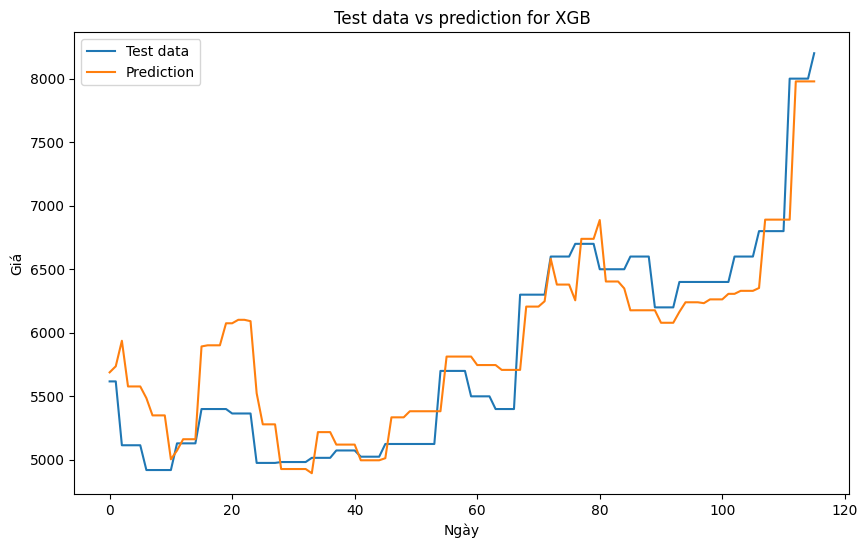

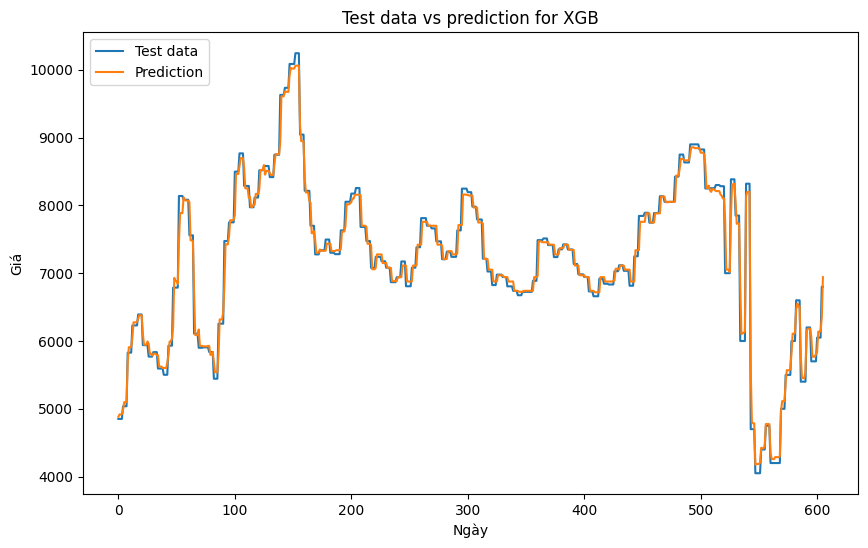

In [ ]:
plot_future(predict_model_oil(model_xgb, X_test), 'XGB', y_test)
plot_future(predict_model_oil(model_xgb, X_train), 'XGB', y_train)

In [ ]:
# DỰ ĐOÁN NGÀY TIẾP THEO
def predict_new_day(model, days, timesteps):
    df_pre = df.copy()
    df_pre_transform = scaler.transform(df_pre)

    # Lấy dữ liệu cuối cùng từ tập dữ liệu
    last_data = df_pre_transform[-timesteps:]
    last_data = last_data.reshape(1, -1)[:, -(timesteps - 1):]

    predicted_prices = []
    for day in range(days):
        next_prediction = model.predict(last_data)
        last_data = np.append(last_data, next_prediction).reshape(1, -1)[:, 1:]
        predicted_price = scaler.inverse_transform(next_prediction.reshape(-1, 1))
        predicted_prices.append(predicted_price[0, 0])
        
    last_date = df_pre.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=days, freq='D')

    predicted_df = pd.DataFrame(index = future_dates, columns=['price'])

    for day, price in enumerate(predicted_prices, start=1):
        predicted_df.loc[last_date + pd.DateOffset(days=day)] = price

    df_pre = pd.concat([df_pre, predicted_df], axis=0)
    return df_pre, predicted_df

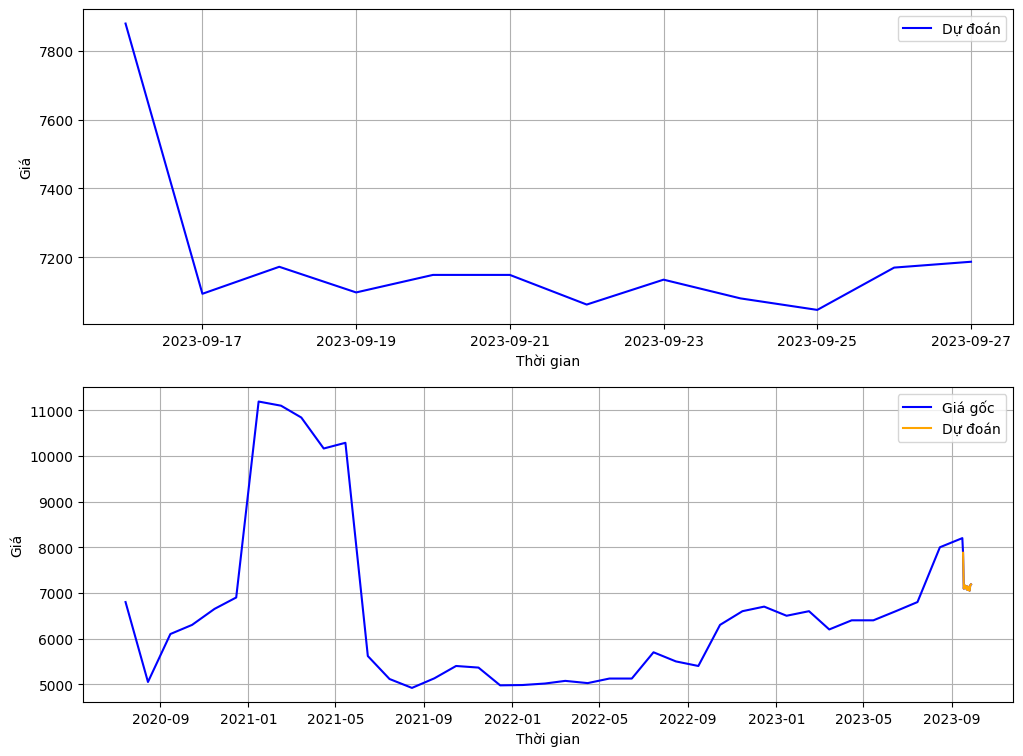

In [ ]:
def plot_pred_data(model, day, timesteps):
    predicted_df_xgb, predicted_df = predict_new_day(model, day, timesteps)

    figure, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 9)) 

    ax1.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='blue')

    ax1.set_xlabel('Thời gian')
    ax1.set_ylabel('Giá')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(predicted_df_xgb[150:].index, predicted_df_xgb[150:]['price'], label='Giá gốc', color='blue')
    ax2.plot(predicted_df.index, predicted_df['price'], label='Dự đoán', color='orange')

    ax2.set_xlabel('Thời gian')
    ax2.set_ylabel('Giá')
    ax2.legend()
    ax2.grid(True)

    # Hiển thị biểu đồ
    plt.show()

plot_pred_data(model_xgb, 12, 49)

### Random Forest

In [ ]:
X_train_rf, y_train_rf = X_train, y_train
X_test_rf, y_test_rf = X_test, y_test

In [ ]:
# Tạo và huấn luyện mô hình Random Forest
model_rf = RandomForestRegressor(n_estimators=60, max_depth=5)

model_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=5, n_estimators=60)

In [ ]:
evaluate_predict(model_rf, X_train_rf, y_train_rf, 'Random forest trên tập train').head()

Đánh giá mô hình Random forest trên tập train


,MSE,RMSE,R2
0,37253.539078,193.011759,0.972844


In [ ]:
evaluate_predict(model_rf, X_test_rf, y_test_rf, 'Random forest trên tập test').head()

Đánh giá mô hình Random forest trên tập test


,MSE,RMSE,R2
0,122111.257501,349.444212,0.813384


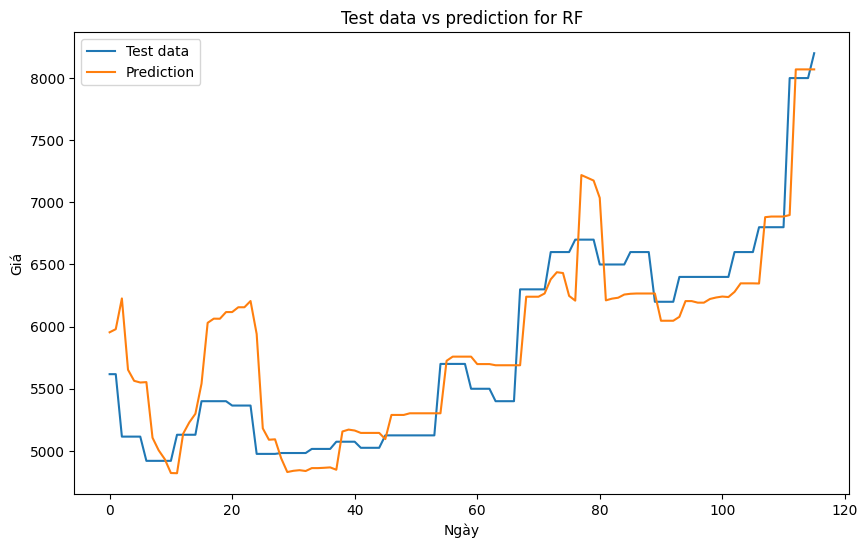

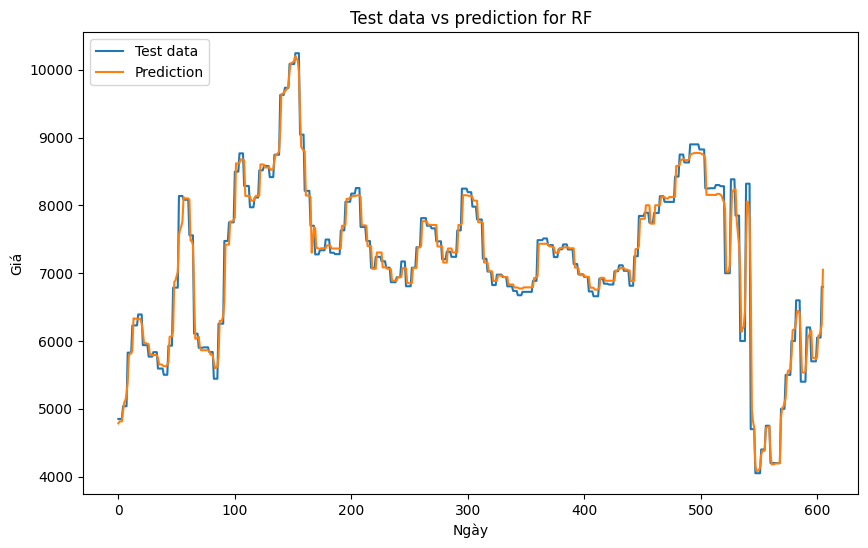

In [ ]:
plot_future(predict_model_oil(model_rf, X_test), 'RF', y_test)
plot_future(predict_model_oil(model_rf, X_train), 'RF', y_train)

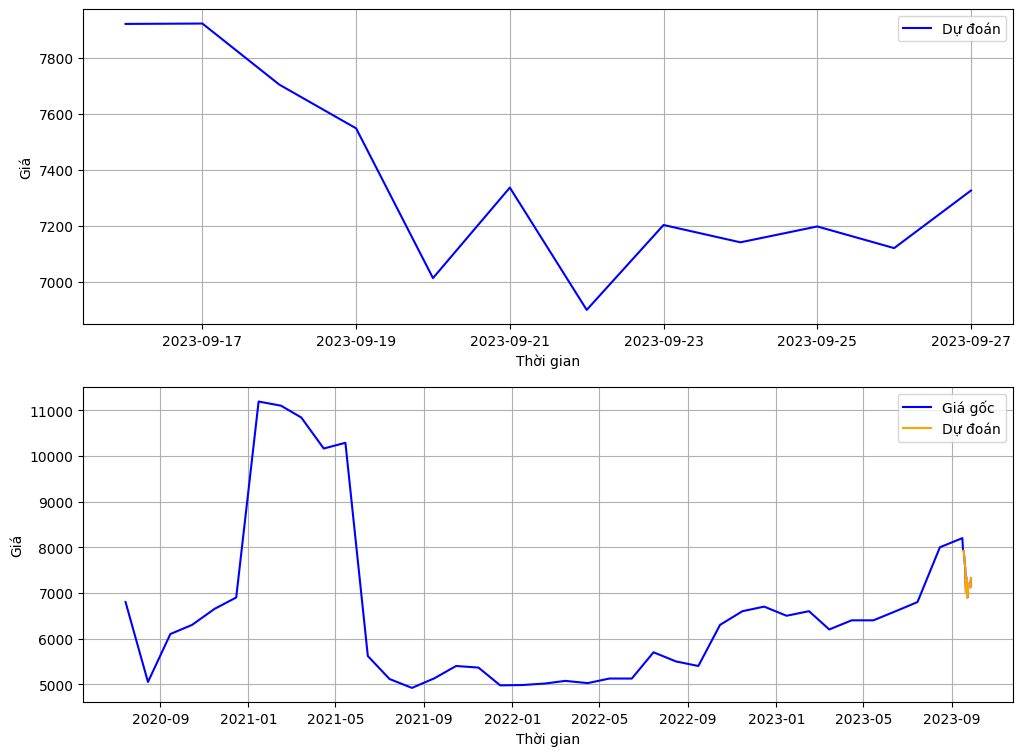

In [ ]:
plot_pred_data(model_rf, 12, 49)

### SVM

In [ ]:
X_train_svm, y_train_svm = X_train, y_train
X_test_svm, y_test_svm = X_test, y_test

In [ ]:
model_svm = SVR(C=5, kernel='rbf', gamma='auto', epsilon=0.01)

model_svm.fit(X_train_svm, y_train_svm)

SVR(C=5, epsilon=0.01, gamma='auto')

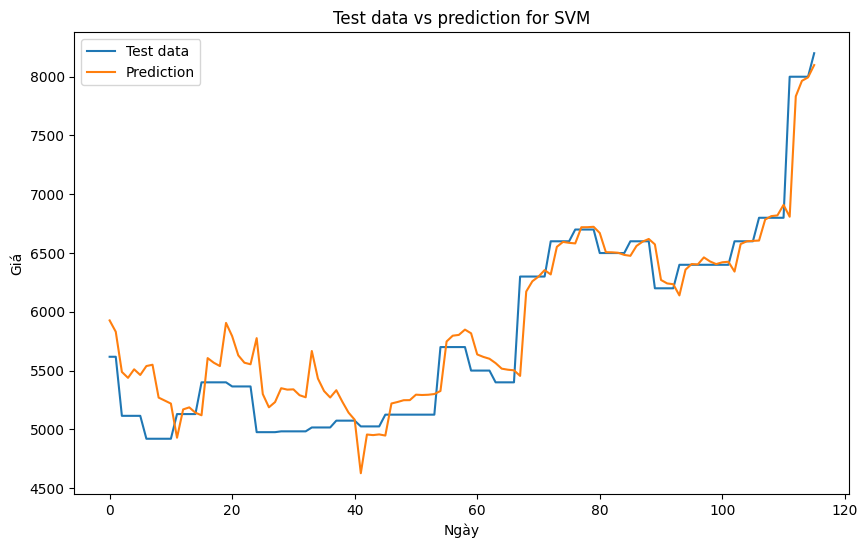

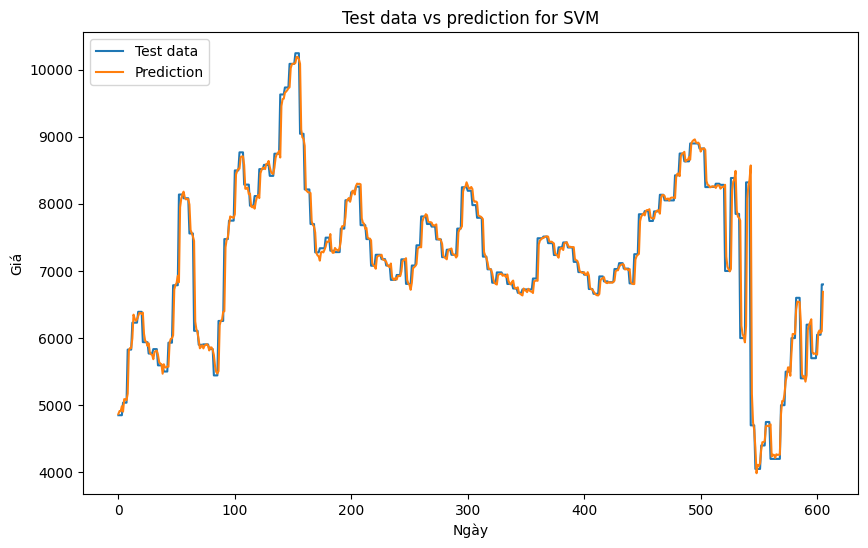

In [ ]:
plot_future(predict_model_oil(model_svm, X_test), 'SVM', y_test)
plot_future(predict_model_oil(model_svm, X_train), 'SVM', y_train)

In [ ]:
evaluate_predict(model_svm, X_train_svm, y_train_svm, 'SVM trên tập train').head()

Đánh giá mô hình SVM trên tập train


,MSE,RMSE,R2
0,75799.474239,275.317043,0.944746


In [ ]:
evaluate_predict(model_svm, X_test_svm, y_test_svm, 'SVM trên tập test').head()

Đánh giá mô hình SVM trên tập test


,MSE,RMSE,R2
0,71324.341051,267.066174,0.890999


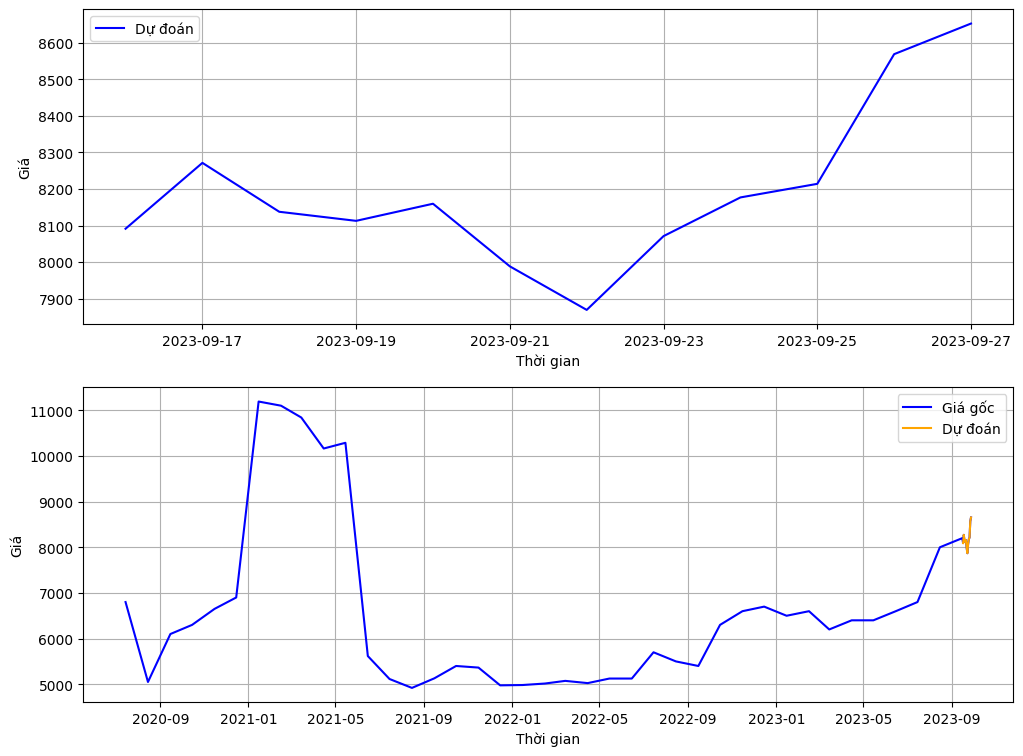

In [ ]:
plot_pred_data(model_svm, 12, 49)

In [ ]:
import joblib

# save the model to a file
joblib.dump(model_lstm, './algricultural/model_lstm.joblib')
joblib.dump(model_gru, './algricultural/model_gru.joblib')
joblib.dump(model_xgb, './algricultural/model_xgboost.joblib')
joblib.dump(model_rf, './algricultural/model_randomforest.joblib')
joblib.dump(model_svm, './algricultural/model_svm.joblib')

